[View in Colaboratory](https://colab.research.google.com/gist/ltiao/c066d22588d9494cb4b94a6cdd472392/approximating-the-kl-divergence-between-implicit-distributions.ipynb)

In [0]:
%matplotlib inline

In [0]:
import numpy as np
from scipy.special import expit

import tensorflow as tf
import tensorflow_probability as tfp

from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.callbacks import Callback

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from matplotlib import animation
from IPython.display import HTML, SVG
from keras.utils.vis_utils import model_to_dot, plot_model

/usr/lib/python3/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [0]:
plt.style.use('seaborn-colorblind')

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif=['Lato'], size=16)
plt.rc('animation', convert_path='/usr/bin/convert')

np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)

In [0]:
'TensorFlow version: ' + tf.__version__

'TensorFlow version: 1.10.0'

In [0]:
sess = tf.InteractiveSession()

In [0]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

In [0]:
mu_p = 1.
sigma_p = 1.

In [0]:
mu_q = 0.
sigma_q = 2.

In [0]:
p = tfp.distributions.Normal(loc=mu_p, scale=sigma_p)
q = tfp.distributions.Normal(loc=mu_q, scale=sigma_q)

In [0]:
xs = tf.expand_dims(tf.linspace(-5., 5., 500), 1)
xs

<tf.Tensor 'ExpandDims:0' shape=(500, 1) dtype=float32>

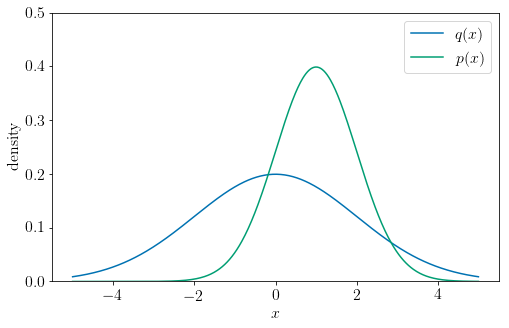

In [0]:
fig, ax = plt.subplots(figsize=golden_size(8))

# ax.set_title('probability densities')

ax.plot(xs.eval(), q.prob(xs).eval(), label='$q(x)$')
ax.plot(xs.eval(), p.prob(xs).eval(), label='$p(x)$')

ax.set_xlim(-5.5, 5.5)
ax.set_ylim(0., .5)

ax.set_xlabel('$x$')
ax.set_ylabel('density')

ax.legend()

plt.savefig('gaussian_1d_densities.svg', format='svg', dpi=1200)

In [0]:
r = density_ratio(p, q)

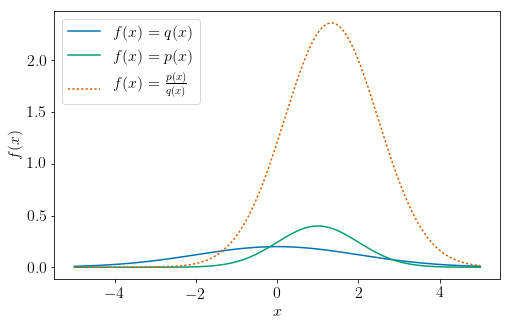

In [0]:
fig, ax = plt.subplots(figsize=golden_size(8))

# ax.set_title('density ratio')

ax.plot(xs.eval(), q.prob(xs).eval(), label='$f(x)=q(x)$')
ax.plot(xs.eval(), p.prob(xs).eval(), label='$f(x)=p(x)$')

ax.plot(xs.eval(), r(xs).eval(), linestyle=':', label='$f(x)=\\frac{p(x)}{q(x)}$')

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('$x$')

ax.set_ylabel('$f(x)$')

ax.legend()

plt.savefig('gaussian_1d_density_ratios.svg', format='svg', dpi=1200)

In [0]:
tfp.distributions.kl_divergence(p, q).eval()

0.44314718

$$
\mathrm{KL}[p(x) || q(x)] = 
\mathbb{E}_{p(x)} \left [ \log \frac{p(x)}{q(x)} \right ].
$$

In [0]:
p_samples = p.sample(5000, seed=8888)
q_samples = q.sample(5000, seed=8888)

In [0]:
log_r = log_density_ratio(p, q)
tf.reduce_mean(log_r(p_samples)).eval()

0.44670376

In [0]:
tfp.monte_carlo.expectation(f=log_r, samples=p_samples).eval()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


0.4581419

$$
\begin{align}
\mathrm{KL}[p(x) || q(x)] 
& = \mathbb{E}_{q(x)} \left [ \frac{p(x)}{q(x)} \log \frac{p(x)}{q(x)} \right ] \\
& = \mathbb{E}_{q(x)} \left [ f \left ( \frac{p(x)}{q(x)} \right ) \right ] 
\end{align}
$$
where
$$
f(u) = u \log u
$$

In [0]:
_kl_forward = lambda u: u * tf.log(u)

In [0]:
us = tf.linspace(0., 2., 500)

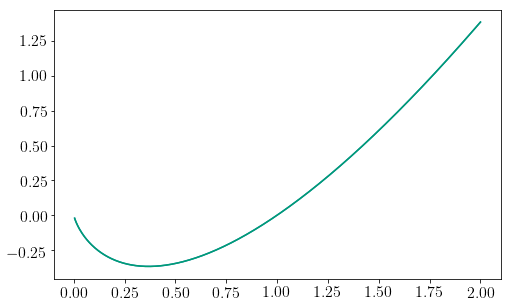

In [0]:
fig, ax = plt.subplots(figsize=golden_size(8))

ax.plot(us.eval(), tfp.vi.kl_forward(tf.log(us)).eval())
ax.plot(us.eval(), _kl_forward(us).eval())

plt.show()

In [0]:
tf.reduce_mean(_kl_forward(tf.exp(log_r(q_samples)))).eval()

0.45856187

In [0]:
tf.reduce_mean(tfp.vi.kl_forward(log_r(q_samples))).eval()

0.4559041

In [0]:
tfp.vi.monte_carlo_csiszar_f_divergence(f=tfp.vi.kl_forward,
                                        p_log_prob=p.log_prob, q=q, 
                                        num_draws=5000, seed=888).eval()

0.4430853

In [0]:
def optimal_classifier(p, q): 
    
    def classifier(x):
        
        return tf.truediv(p.prob(x), p.prob(x) + q.prob(x))
    
    return classifier

In [0]:
n_p = n_q = 200

In [0]:
p_samples = p.sample(sample_shape=(n_p, 1), seed=8888)
q_samples = q.sample(sample_shape=(n_q, 1), seed=8888)

In [0]:
X = tf.concat([p_samples, q_samples], axis=0)
X

<tf.Tensor 'concat:0' shape=(400, 1) dtype=float32>

In [0]:
y = tf.concat([tf.ones_like(p_samples), 
               tf.zeros_like(q_samples)], axis=0)
y

<tf.Tensor 'concat_1:0' shape=(400, 1) dtype=float32>

In [0]:
golden_size(8)

(8, 4.944271909999158)

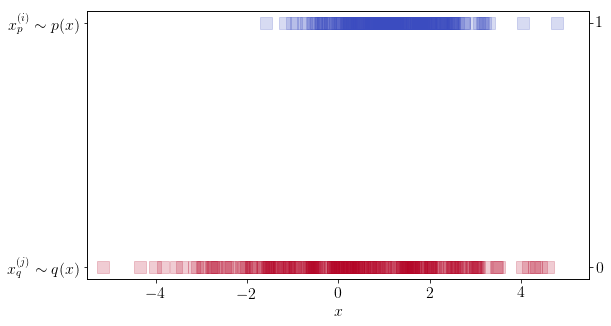

In [0]:
fig, ax1 = plt.subplots(figsize=(9, golden_size(8)[1]))

ax1.scatter(X.eval(), y.eval(), c=y.eval(), s=12.**2, 
           marker='s', alpha=.2, cmap='coolwarm_r')

ax1.set_xlabel('$x$')
ax1.set_xlim(-5.5, 5.5)

ax1.set_ylim(-0.05, 1.05)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['$x_q^{(j)} \sim q(x)$', 
                     '$x_p^{(i)} \sim p(x)$'])

ax2 = ax1.twinx()

ax2.set_ylim(-0.05, 1.05)
ax2.set_yticks([0, 1])

# plt.show()
plt.savefig('dataset.svg', format='svg', dpi=1200)

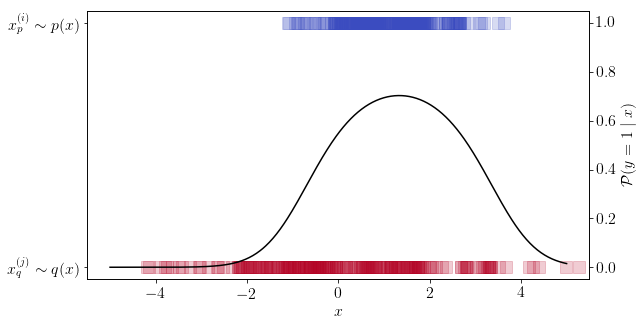

In [0]:
fig, ax1 = plt.subplots(figsize=(9, golden_size(8)[1]))

ax1.scatter(X.eval(), y.eval(), c=y.eval(), s=12.**2, 
            marker='s', alpha=.2, cmap='coolwarm_r')

ax1.set_xlabel('$x$')
ax1.set_xlim(-5.5, 5.5)

ax1.set_ylim(-0.05, 1.05)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['$x_q^{(j)} \sim q(x)$', 
                     '$x_p^{(i)} \sim p(x)$'])

ax2 = ax1.twinx()

ax2.plot(xs.eval(), optimal_classifier(p, q)(xs).eval(), 'k-')

ax2.set_xlim(-5.5, 5.5)
ax2.set_xlabel('$x$')

ax2.set_ylim(-0.05, 1.05)
ax2.set_ylabel('$\mathcal{P}(y=1 \mid x)$')

# plt.show()
plt.savefig('optimal_classifier.svg', format='svg', dpi=1200)

In [0]:
log_ratio = Sequential([
    Dense(16, input_dim=1, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1),
])

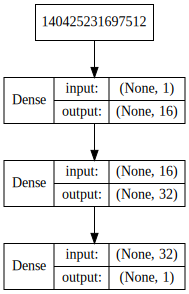

In [0]:
SVG(model_to_dot(log_ratio, show_layer_names=False, show_shapes=True)
    .create(prog='dot', format='svg'))

In [0]:
plot_model(model=log_ratio, 
           show_layer_names=False, 
           show_shapes=True,
           to_file='log_ratio_architecture.svg')

In [0]:
x_p = Input(tensor=p_samples)
x_q = Input(tensor=q_samples)

In [0]:
log_ratio_p = log_ratio(x_p)
log_ratio_q = log_ratio(x_q)

In [0]:
def _binary_crossentropy(log_ratio_p, log_ratio_q):

    loss_p = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=log_ratio_p,
        labels=tf.ones_like(log_ratio_p)
    )

    loss_q = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=log_ratio_q,
        labels=tf.zeros_like(log_ratio_q)
    )

    return tf.reduce_mean(loss_p + loss_q)

In [0]:
m = Model(inputs=[x_p, x_q], outputs=[log_ratio_p, log_ratio_q])
m.add_loss(_binary_crossentropy(log_ratio_p, log_ratio_q))
m.compile(optimizer='rmsprop', loss=None)

In [0]:
m.evaluate(x=None, steps=1)

1/1 [==============================] - 0s 215ms/step


1.357100009918213

In [0]:
class PredictionHistory(Callback):
        
    def __init__(self):

        self.predictions = []

    def on_epoch_begin(self, epoch, logs):

        self.predictions.append(log_ratio(xs).eval())

In [0]:
hist_pred = PredictionHistory()

In [0]:
hist = m.fit(x=None, y=None, steps_per_epoch=1, epochs=500, callbacks=[hist_pred])

Epoch 1/500
1/1 [==============================] - 0s 78ms/step - loss: 1.3547
Epoch 2/500
1/1 [==============================] - 0s 5ms/step - loss: 1.3460
Epoch 3/500
1/1 [==============================] - 0s 4ms/step - loss: 1.3390
Epoch 4/500
1/1 [==============================] - 0s 5ms/step - loss: 1.3300
Epoch 5/500
1/1 [==============================] - 0s 4ms/step - loss: 1.3306
Epoch 6/500
1/1 [==============================] - 0s 4ms/step - loss: 1.3242
Epoch 7/500
1/1 [==============================] - 0s 5ms/step - loss: 1.3223
Epoch 8/500
1/1 [==============================] - 0s 4ms/step - loss: 1.3107
Epoch 9/500
1/1 [==============================] - 0s 5ms/step - loss: 1.3164
Epoch 10/500
1/1 [==============================] - 0s 4ms/step - loss: 1.3135
Epoch 11/500
1/1 [==============================] - 0s 4ms/step - loss: 1.3016
Epoch 12/500
1/1 [==============================] - 0s 4ms/step - loss: 1.3139
Epoch 13/500
1/1 [==============================] - 0s 4ms/s

Epoch 105/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1397
Epoch 106/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1793
Epoch 107/500
1/1 [==============================] - 0s 3ms/step - loss: 1.1838
Epoch 108/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1497
Epoch 109/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1473
Epoch 110/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1939
Epoch 111/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1742
Epoch 112/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1274
Epoch 113/500
1/1 [==============================] - 0s 3ms/step - loss: 1.1267
Epoch 114/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1457
Epoch 115/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1577
Epoch 116/500
1/1 [==============================] - 0s 3ms/step - loss: 1.1902
Epoch 117/500
1/1 [=====================

Epoch 208/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1214
Epoch 209/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1719
Epoch 210/500
1/1 [==============================] - 0s 4ms/step - loss: 1.0741
Epoch 211/500
1/1 [==============================] - 0s 4ms/step - loss: 1.2381
Epoch 212/500
1/1 [==============================] - 0s 3ms/step - loss: 1.1877
Epoch 213/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1771
Epoch 214/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1602
Epoch 215/500
1/1 [==============================] - 0s 3ms/step - loss: 1.1639
Epoch 216/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1249
Epoch 217/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1204
Epoch 218/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1316
Epoch 219/500
1/1 [==============================] - 0s 3ms/step - loss: 1.1622
Epoch 220/500
1/1 [=====================

Epoch 311/500
1/1 [==============================] - 0s 4ms/step - loss: 1.0795
Epoch 312/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1356
Epoch 313/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1719
Epoch 314/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1513
Epoch 315/500
1/1 [==============================] - 0s 3ms/step - loss: 1.0873
Epoch 316/500
1/1 [==============================] - 0s 3ms/step - loss: 1.1608
Epoch 317/500
1/1 [==============================] - 0s 3ms/step - loss: 1.1580
Epoch 318/500
1/1 [==============================] - 0s 5ms/step - loss: 1.1041
Epoch 319/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1493
Epoch 320/500
1/1 [==============================] - 0s 3ms/step - loss: 1.0978
Epoch 321/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1575
Epoch 322/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1235
Epoch 323/500
1/1 [=====================

Epoch 414/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1267
Epoch 415/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1004
Epoch 416/500
1/1 [==============================] - 0s 3ms/step - loss: 1.1560
Epoch 417/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1078
Epoch 418/500
1/1 [==============================] - 0s 3ms/step - loss: 1.1266
Epoch 419/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1249
Epoch 420/500
1/1 [==============================] - 0s 3ms/step - loss: 1.0938
Epoch 421/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1103
Epoch 422/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1749
Epoch 423/500
1/1 [==============================] - 0s 3ms/step - loss: 1.1478
Epoch 424/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1011
Epoch 425/500
1/1 [==============================] - 0s 4ms/step - loss: 1.1179
Epoch 426/500
1/1 [=====================

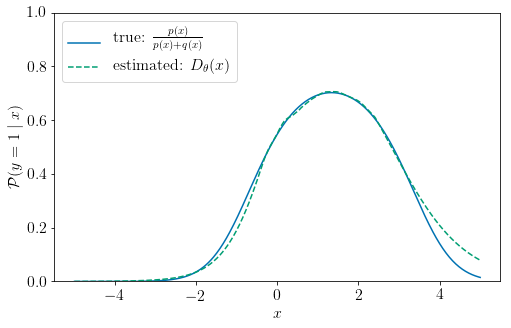

In [0]:
fig, ax = plt.subplots(figsize=golden_size(8))

# ax.set_title('Class probabilities')

ax.plot(xs.eval(), optimal_classifier(p, q)(xs).eval(), label='true: $\\frac{p(x)}{p(x) + q(x)}$')
ax.plot(xs.eval(), tf.sigmoid(log_ratio(xs)).eval(), 
        linestyle='--', label='estimated: $D_{\\theta}(x)$')

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('$x$')

ax.set_ylim(0., 1.)
ax.set_ylabel('$\mathcal{P}(y=1 \mid x)$')

ax.legend(loc='upper left')

# plt.show()
plt.savefig('class_probability_estimation.svg', format='svg', dpi=1200)

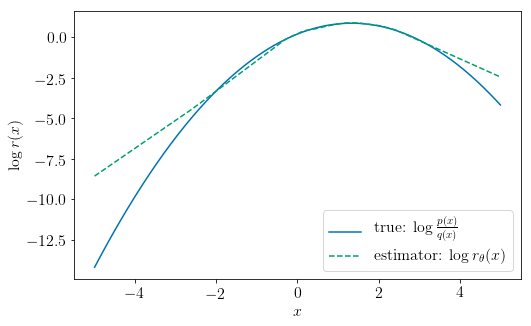

In [0]:
fig, ax = plt.subplots(figsize=golden_size(8))

# ax.set_title('Log density ratio')

ax.plot(xs.eval(), tf.log(r(xs)).eval(), label='true: $\log \\frac{p(x)}{q(x)}$')
ax.plot(xs.eval(), log_ratio(xs).eval(), 
        linestyle='--', label='estimator: $\log r_{\\theta}(x)$')

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('$x$')

ax.set_ylabel('$\log r(x)$')

ax.legend(loc='lower right')

# plt.show()
plt.savefig('log_density_ratio_estimation.svg', format='svg', dpi=1200)

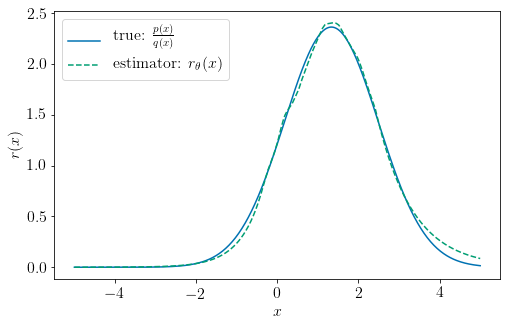

In [0]:
fig, ax = plt.subplots(figsize=golden_size(8))

# ax.set_title('Density ratio')

ax.plot(xs.eval(), r(xs).eval(), label='true: $\\frac{p(x)}{q(x)}$')
ax.plot(xs.eval(), tf.exp(log_ratio(xs)).eval(), 
        linestyle='--', label='estimator: $r_{\\theta}(x)$')

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('$x$')

ax.set_ylabel('$r(x)$')

ax.legend(loc='upper left')

# plt.show()
plt.savefig('density_ratio_estimation.svg', format='svg', dpi=1200)

#### KL Divergence 

$$
\begin{align}
\mathrm{KL}[p(x) \| q(x)]
= \mathbb{E}_{p(x)} [ \log r(x) ] 
& \approx \mathbb{E}_{p(x)} [ \log \hat{r}(x) ] \\ 
& \approx
\frac{1}{M} \sum_{i=1}^{M} \log \hat{r} (x_p^{(i)}) \\
& = 
\frac{1}{M} \sum_{i=1}^{M} \sigma^{-1}(\hat{D}(x_p^{(i)})), 
\quad x_p^{(i)} \sim p(x).
\end{align}
$$

In [0]:
tf.squeeze(tfp.monte_carlo.expectation(
    f=log_ratio,
    samples=p_samples
)).eval()

0.4424468

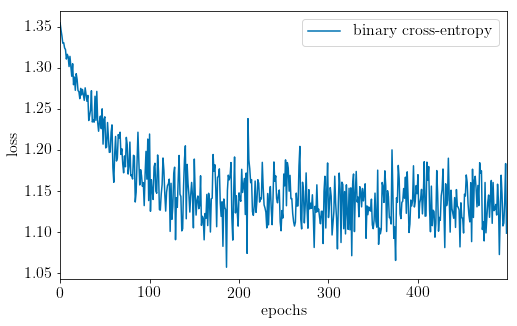

In [0]:
fig, ax = plt.subplots(figsize=golden_size(8))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax, y='loss', label='binary cross-entropy')

ax.set_ylabel('loss')
ax.set_xlabel('epochs')

# plt.show()
plt.savefig('binary_crossentropy.svg', format='svg', dpi=1200)

In [0]:
js = tfp.vi.monte_carlo_csiszar_f_divergence(f=tfp.vi.jensen_shannon, 
                                             p_log_prob=p.log_prob, 
                                             q=q, num_draws=50000)

In [0]:
js.eval()

-1.128503

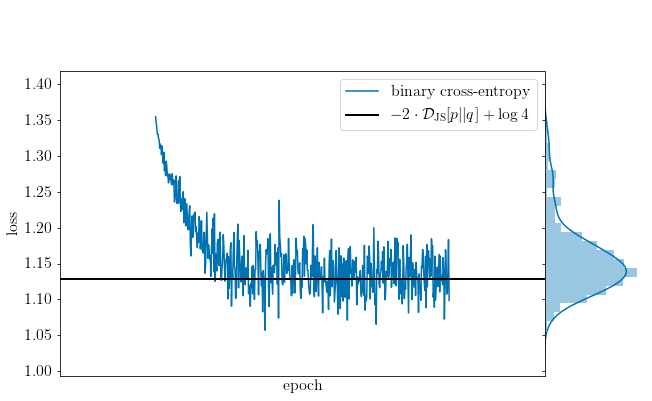

In [0]:
g = sns.JointGrid(x='index', y='loss', 
                  data=hist_df.reset_index(), space=0)

h, w = golden_size(10)

g.fig.set_figwidth(h)
g.fig.set_figheight(w)

g = g.plot_joint(plt.plot, label='binary cross-entropy')
g = g.plot_marginals(sns.distplot)

g.ax_marg_x.clear()
g.ax_marg_x.set_xticks([])
g.ax_marg_x.set_yticks([])
# g.ax_marg_x.set_axis_off()

g.ax_joint.axhline(y=-js.eval(), color='k', linewidth=2.,
                   label='$- 2 \cdot \mathcal{D}_{\mathrm{JS}}[p || q ] + \log{4}$')

g.ax_joint.legend(loc='upper right')
g.set_axis_labels('epoch', 'loss')

g.savefig('binary_crossentropy_vs_jensen_shannon.svg', format='svg', dpi=1200)

In [0]:
# fig, ax = plt.subplots(figsize=golden_size(8))

# hist_df = pd.DataFrame(hist.history)
# hist_df.plot(ax=ax, y='loss', label='binary cross-entropy')

# ax.axhline(y=-js.eval(), 
#            color='r', linewidth=2., 
#            label='$- 2 \cdot \mathcal{D}_{\mathrm{JS}}[p || q ] + \log{4}$')

# ax.set_ylabel('loss')
# ax.set_xlabel('epochs')

# ax.legend()

# # plt.show()
# plt.savefig('binary_crossentropy_vs_jensen_shannon.svg', format='svg', dpi=1200)

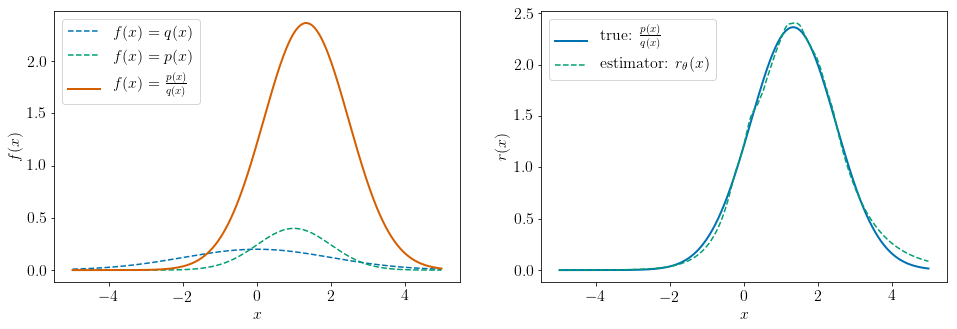

In [0]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

# ax.set_title('density ratio')

ax1.plot(xs.eval(), q.prob(xs).eval(), linestyle='--', label='$f(x)=q(x)$')
ax1.plot(xs.eval(), p.prob(xs).eval(), linestyle='--', label='$f(x)=p(x)$')

ax1.plot(xs.eval(), r(xs).eval(), linewidth=2., label='$f(x)=\\frac{p(x)}{q(x)}$')

ax1.set_xlim(-5.5, 5.5)
ax1.set_xlabel('$x$')

ax1.set_ylabel('$f(x)$')

ax1.legend()

# ax2.set_title('Density ratio')

ax2.plot(xs.eval(), r(xs).eval(), linewidth=2., label='true: $\\frac{p(x)}{q(x)}$')
ax2.plot(xs.eval(), tf.exp(log_ratio(xs)).eval(), 
        linestyle='--', label='estimator: $r_{\\theta}(x)$')

ax2.set_xlim(-5.5, 5.5)
ax2.set_xlabel('$x$')

ax2.set_ylabel('$r(x)$')

ax2.legend()

# plt.show()
plt.savefig('dre.png', format='png', dpi=720)

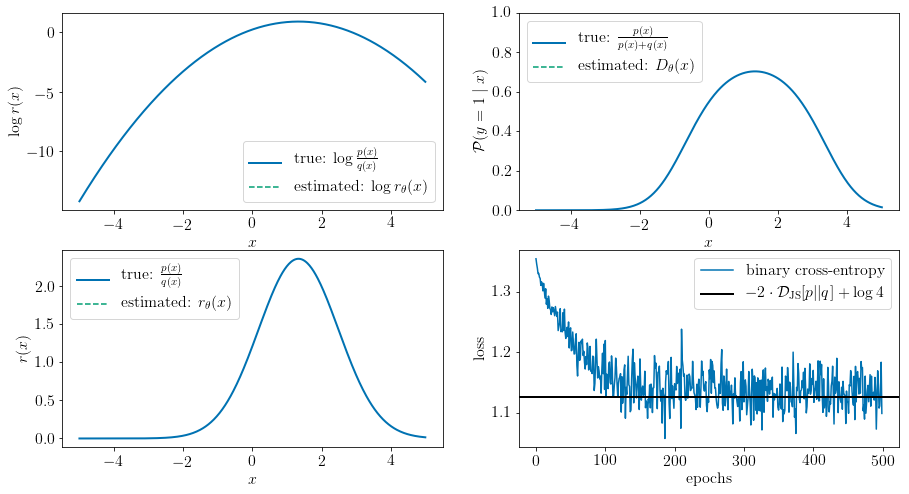

In [0]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

ax1.plot(xs.eval(), tf.log(r(xs)).eval(), linewidth=2., label='true: $\log \\frac{p(x)}{q(x)}$')
line1, = ax1.plot([], [], linestyle='--', label='estimated: $\log r_{\\theta}(x)$')

ax1.set_xlim(-5.5, 5.5)
ax1.set_xlabel('$x$')

ax1.set_ylabel('$\log r(x)$')

ax1.legend(loc='lower right')

ax2.plot(xs.eval(), optimal_classifier(p, q)(xs).eval(), linewidth=2., label='true: $\\frac{p(x)}{p(x) + q(x)}$')
line2, = ax2.plot([], [], linestyle='--', label='estimated: $D_{\\theta}(x)$')

ax2.set_xlim(-5.5, 5.5)
ax2.set_xlabel('$x$')

ax2.set_ylim(0., 1.)
ax2.set_ylabel('$\mathcal{P}(y=1 \mid x)$')

ax2.legend(loc='upper left')

ax3.plot(xs.eval(), r(xs).eval(), linewidth=2., label='true: $\\frac{p(x)}{q(x)}$')
line3, = ax3.plot([], [], linestyle='--', label='estimated: $r_{\\theta}(x)$')

ax3.set_xlim(-5.5, 5.5)
ax3.set_xlabel('$x$')

ax3.set_ylabel('$r(x)$')

ax3.legend(loc='upper left')

hist_df = pd.DataFrame(hist.history)
line4, = ax4.plot(hist_df, label='binary cross-entropy')
ax4.axhline(y=-js.eval(), color='k', linewidth=2.,
            label='$- 2 \cdot \mathcal{D}_{\mathrm{JS}}[p || q ] + \log{4}$')

ax4.set_ylabel('loss')
ax4.set_xlabel('epochs')

ax4.legend(loc='upper right')

plt.show()

In [0]:
def init():

    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])

    return line1, line2, line3, line4

In [0]:
def animate(i):

    xs_ = xs.eval()

    line1.set_xdata(xs_)
    line2.set_xdata(xs_)
    line3.set_xdata(xs_)
    line4.set_xdata(hist.epoch[:i])
    
    line1.set_ydata(hist_pred.predictions[i])
    line2.set_ydata(expit(hist_pred.predictions[i]))
    line3.set_ydata(np.exp(hist_pred.predictions[i]))
    line4.set_ydata(hist.history.get('loss')[:i])

    return line1, line2, line3, line4

In [0]:
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=hist.epoch, interval=60, 
                               blit=True, repeat_delay=5)

In [0]:
HTML(anim.to_html5_video())

In [0]:
anim.save('dre_training.mp4')

In [0]:
anim.save('dre_training.gif', writer='imagemagick')